In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U transformers bitsandbytes accelerate peft
!pip install -q kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 44.4 MB/s eta 0:00:00


# Image based Skin Disease prediction Model

In [ ]:
import tensorflow as tf
import os

# --- ACTION REQUIRED ---
# Updated this path to the location of dataset in Google Drive
drive_path = '/content/drive/MyDrive/ISIC 2019 dataset'
train_directory = os.path.join(drive_path, 'train')

# Check if the path exists
if not os.path.exists(train_directory):
    print(f"ERROR: The path '{train_directory}' does not exist. Please check your path.")
else:
    print(f"Dataset found at: {train_directory}")

    # Define parameters
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 16

    # Create the training dataset from your Drive
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_directory,
        labels='inferred',
        label_mode='categorical',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Create the validation dataset from your Drive
    val_dataset = tf.keras.utils.image_dataset_from_directory(
        train_directory,
        labels='inferred',
        label_mode='categorical',
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    class_names = train_dataset.class_names
    print("Found classes:", class_names)

Dataset found at: /content/drive/MyDrive/ISIC 2019 dataset/train
Found 25447 files belonging to 8 classes.
Using 20358 files for training.
Found 25447 files belonging to 8 classes.
Using 5089 files for validation.
Found classes: ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# This code works as-is, provided the 'train_directory' is correct
total_samples = 0
num_samples_per_class = []
for class_name in class_names:
    class_dir = os.path.join(train_directory, class_name)
    num_samples = len(os.listdir(class_dir))
    num_samples_per_class.append(num_samples)
    total_samples += num_samples

num_classes = len(class_names)

# Calculate class weights
class_weights = {}
for i in range(num_classes):
    weight = (1 / num_samples_per_class[i]) * (total_samples / num_classes)
    class_weights[i] = weight

print("Calculated Class Weights:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weights[i]:.2f}")

Calculated Class Weights:
  AK: 3.59
  BCC: 0.96
  BKL: 1.20
  DF: 13.31
  MEL: 0.70
  NV: 0.25
  SCC: 5.07
  VASC: 12.57


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache(filename='./tf_train_cache').prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache(filename='./tf_val_cache').prefetch(buffer_size=AUTOTUNE)

print("\nDatasets are now cached and prefetched for better performance.")


Datasets are now cached and prefetched for better performance.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# --- Define the Model ---
# Load the pre-trained ResNet50 model without its top classification layer
base_model = ResNet50(input_shape=(224, 224, 3),
                      include_top=False,
                      weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add your custom classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) # Run base model in inference mode
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # Add dropout for regularization
outputs = Dense(len(class_names), activation='softmax')(x) # Output layer for your classes

# Create the final model
model = Model(inputs, outputs)

# Display the model architecture to verify
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,694,088 (98.02 MB)

 Trainable params: 2,106,376 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# --- Compile the Model ---
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel compiled successfully.")


Model compiled successfully.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Define Callbacks ---
# 1. Save the best performing model
checkpoint_path = "/content/drive/MyDrive/best_skin_model.keras"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   save_best_only=True,
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1)

# 2. Stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10, # Number of epochs to wait for improvement
                               restore_best_weights=True,
                               verbose=1)

# --- Start Training ---
print("\nStarting model training...")

NUM_EPOCHS = 40

history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=[model_checkpoint, early_stopping]
)

print("\nTraining complete!")


Starting model training...
Epoch 1/40
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3246 - loss: 2.5748
Epoch 1: val_accuracy improved from -inf to 0.53567, saving model to /content/drive/MyDrive/best_skin_model.keras
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4062s 3s/step - accuracy: 0.3247 - loss: 2.5744 - val_accuracy: 0.5357 - val_loss: 1.2825
Epoch 2/40
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3876 - loss: 1.6585
Epoch 2: val_accuracy did not improve from 0.53567
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 78s 61ms/step - accuracy: 0.3876 - loss: 1.6585 - val_accuracy: 0.4913 - val_loss: 1.3343
Epoch 3/40
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3868 - loss: 1.6240
Epoch 3: val_accuracy improved from 0.53567 to 0.55708, saving model to /content/drive/MyDrive/best_skin_model.keras
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 77s 61ms/step - accuracy: 0.3868 - loss: 1.6239 - val_accuracy: 0.5571 - val_loss: 1.2247
Epoch 4/40
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accur

In [ ]:
# --- 1. Unfreeze the base model ---
base_model.trainable = True
print(f"Number of layers in the base model: {len(base_model.layers)}")

# It's a good practice to re-freeze the very first layers (e.g., the first 100)
# as they learn very generic features. Let's fine-tune the rest.
fine_tune_from = 100
for layer in base_model.layers[:fine_tune_from]:
    layer.trainable = False

# --- 2. Re-compile the model with a very low learning rate ---
# This is critical for fine-tuning to prevent destroying the pre-trained weights.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary() # Note the massive increase in trainable parameters

# --- 3. Continue training ---
# We'll continue for more epochs to fine-tune the newly unfrozen layers.
fine_tune_epochs = 80
total_epochs = NUM_EPOCHS + fine_tune_epochs

history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where you left off
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=[model_checkpoint, early_stopping] # Use the same callbacks
)

Number of layers in the base model: 175


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,694,088 (98.02 MB)

 Trainable params: 21,559,304 (82.24 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Epoch 40/120
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5519 - loss: 21.2943
Epoch 40: val_accuracy did not improve from 0.64296
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 188s 122ms/step - accuracy: 0.5519 - loss: 21.2860 - val_accuracy: 0.5317 - val_loss: 1.7390
Epoch 41/120
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4837 - loss: 1.7729
Epoch 41: val_accuracy did not improve from 0.64296
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 137s 107ms/step - accuracy: 0.4837 - loss: 1.7727 - val_accuracy: 0.5677 - val_loss: 1.2888
Epoch 42/120
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5269 - loss: 1.1735
Epoch 42: val_accuracy did not improve from 0.64296
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 137s 107ms/step - accuracy: 0.5269 - loss: 1.1734 - val_accuracy: 0.5791 - val_loss: 1.1586
Epoch 43/120
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5521 - loss: 0.9739
Epoch 43: val_accuracy did not improve from 0.64296
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 136s 107ms/step - accurac

### Image Model Evaluation

--- Configuration ---
Dataset Path: /content/drive/MyDrive/ISIC2019dataset/train
Model Path:   /content/drive/MyDrive/DEEPLEARNINGSKINMODEL/best_skin_model.keras

Loading validation dataset...
Found 25447 files belonging to 8 classes.
Using 5089 files for validation.
Classes found: ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

Loading model from /content/drive/MyDrive/DEEPLEARNINGSKINMODEL/best_skin_model.keras...
Model loaded successfully.

Running predictions on validation set... (This may take a moment)
Prediction complete.

--- Classification Report ---
              precision    recall  f1-score   support

          AK     0.5600    0.5490    0.5545       153
         BCC     0.7134    0.8245    0.7649       661
         BKL     0.5867    0.5618    0.5740       518
          DF     0.6087    0.4912    0.5437        57
         MEL     0.6648    0.6655    0.6652       894
          NV     0.8690    0.8611    0.8651      2628
         SCC     0.6410    0.4065    0.4975    

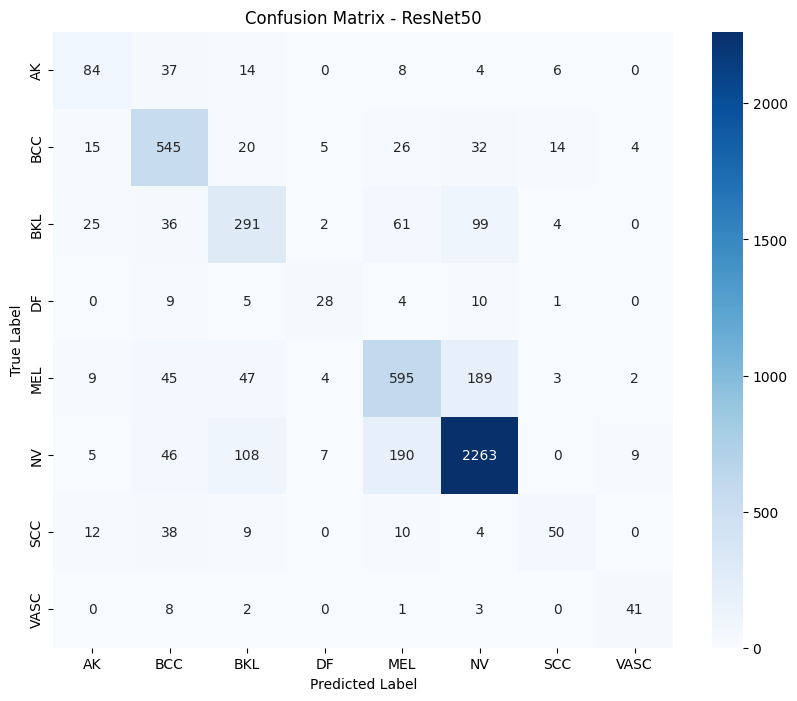


--- ROC Curves ---


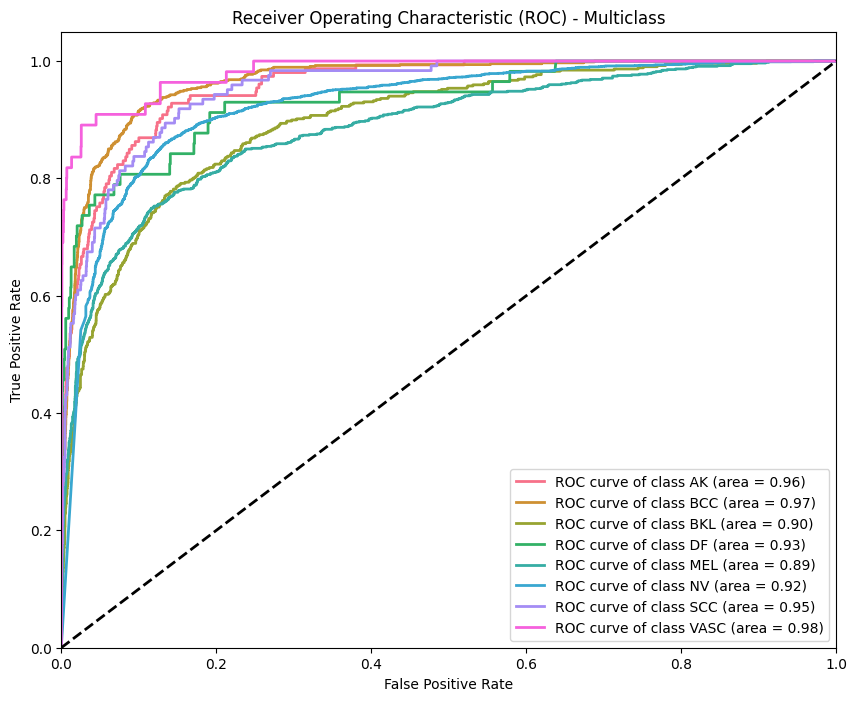

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os

# --- 1. CONFIGURATION ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
DRIVE_PATH = '/content/drive/MyDrive/ISIC2019dataset'
TRAIN_DIRECTORY = os.path.join(DRIVE_PATH, 'train')
MODEL_PATH = '/content/drive/MyDrive/DEEPLEARNINGSKINMODEL/best_skin_model.keras'

print("--- Configuration ---")
print(f"Dataset Path: {TRAIN_DIRECTORY}")
print(f"Model Path:   {MODEL_PATH}")

# --- 2. LOAD DATA & MODEL ---
# We reload the validation dataset exactly as it was split during training
# to ensure we evaluate on the correct unseen data.
print("\nLoading validation dataset...")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123, # CRITICAL: Must match training seed to get same split
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = val_dataset.class_names
print(f"Classes found: {class_names}")

print(f"\nLoading model from {MODEL_PATH}...")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Ensure the path is correct and the drive is mounted.")
    # Stop execution if model fails to load
    raise e

# --- 3. RUN PREDICTIONS ---
print("\nRunning predictions on validation set... (This may take a moment)")

y_true_indices = []
y_pred_probs = []

# Iterate through the dataset to get true labels and predictions
# We do this manually to ensure they align perfectly
for images, labels in val_dataset:
    # Get True Labels (convert from one-hot if needed)
    # label_mode='categorical' means labels are one-hot encoded
    y_true_batch = np.argmax(labels.numpy(), axis=1)
    y_true_indices.extend(y_true_batch)

    # Get Predictions
    probs = model.predict(images, verbose=0)
    y_pred_probs.extend(probs)

# Convert lists to numpy arrays
y_true_indices = np.array(y_true_indices)
y_pred_probs = np.array(y_pred_probs)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

print("Prediction complete.")

# --- 4. CLASSIFICATION REPORT ---
print("\n--- Classification Report ---")
report = classification_report(
    y_true_indices,
    y_pred_indices,
    target_names=class_names,
    digits=4
)
print(report)

# --- 5. CONFUSION MATRIX ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true_indices, y_pred_indices)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ResNet50')
plt.show()

# --- 6. ROC CURVE (Multiclass) ---
print("\n--- ROC Curves ---")
# Binarize the output for multiclass ROC
y_true_bin = label_binarize(y_true_indices, classes=range(len(class_names)))
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", n_classes)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()

Saving generated images to: /content/report_images

--- Generating Figure 1.1: Class Distribution ---
Counting files...
  AK: 885
  BCC: 3327
  BKL: 2652
  DF: 239
  MEL: 4563
  NV: 12900
  SCC: 628
  VASC: 253


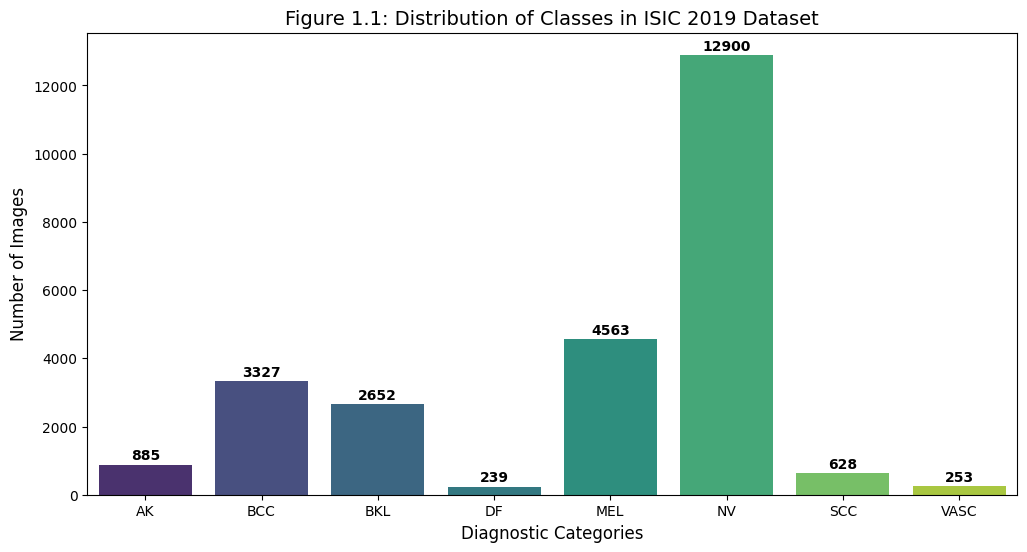

Saved to /content/report_images/fig_1_1_class_distribution.png

--- Generating Figure 3.2: Residual Block Schematic ---
Saved schematic to /content/report_images/fig_3_2_residual_block.png


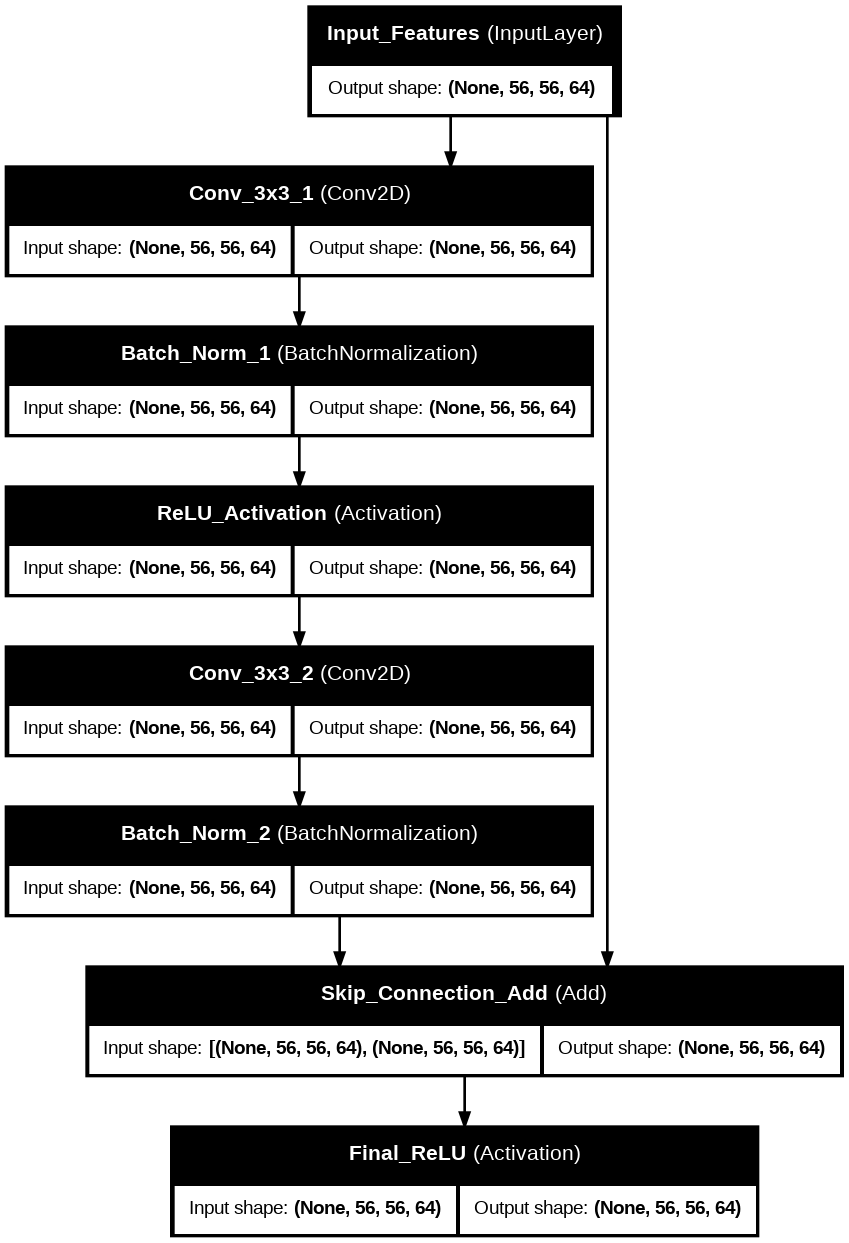


--- Generating Figure 3.1: Full Model Architecture ---
Saved full architecture to /content/report_images/fig_3_1_resnet_architecture.png
Note: This image might be very large/tall due to ResNet depth.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import plot_model

# --- CONFIGURATION ---
# Ensure this path matches your Drive structure
DRIVE_PATH = '/content/drive/MyDrive/ISIC 2019 dataset'
TRAIN_DIR = os.path.join(DRIVE_PATH, 'train')
MODEL_PATH = '/content/drive/MyDrive/best_skin_model.keras'
SAVE_DIR = '/content/report_images' # Where to save the generated images

# Create directory to save images
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"Saving generated images to: {SAVE_DIR}")

# ==========================================
# FIGURE 1.1: DISTRIBUTION OF CLASSES
# ==========================================
def generate_class_distribution(data_dir):
    print("\n--- Generating Figure 1.1: Class Distribution ---")
    if not os.path.exists(data_dir):
        print(f"Error: Dataset path {data_dir} not found.")
        return

    class_names = sorted(os.listdir(data_dir))
    # Filter out non-folders just in case
    class_names = [c for c in class_names if os.path.isdir(os.path.join(data_dir, c))]

    counts = []
    print("Counting files...")
    for c in class_names:
        count = len(os.listdir(os.path.join(data_dir, c)))
        counts.append(count)
        print(f"  {c}: {count}")

    # Plotting
    plt.figure(figsize=(12, 6))
    # Using a distinct palette to visualize imbalance clearly
    sns.barplot(x=class_names, y=counts, hue=class_names, palette='viridis', legend=False)

    plt.title('Figure 1.1: Distribution of Classes in ISIC 2019 Dataset', fontsize=14)
    plt.xlabel('Diagnostic Categories', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=0)

    # Add count labels on top of bars
    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center', va='bottom', fontweight='bold')

    save_path = os.path.join(SAVE_DIR, 'fig_1_1_class_distribution.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"Saved to {save_path}")

# ==========================================
# FIGURE 3.2: RESIDUAL BLOCK STRUCTURE
# ==========================================
def generate_residual_block_diagram():
    print("\n--- Generating Figure 3.2: Residual Block Schematic ---")
    # We build a tiny model just to visualize the concept of a Skip Connection

    inputs = Input(shape=(56, 56, 64), name="Input_Features")

    # Main path
    x = layers.Conv2D(64, (3, 3), padding='same', name="Conv_3x3_1")(inputs)
    x = layers.BatchNormalization(name="Batch_Norm_1")(x)
    x = layers.Activation('relu', name="ReLU_Activation")(x)
    x = layers.Conv2D(64, (3, 3), padding='same', name="Conv_3x3_2")(x)
    x = layers.BatchNormalization(name="Batch_Norm_2")(x)

    # Skip connection (The Identity Mapping)
    # Adding original input to the processed output
    x = layers.Add(name="Skip_Connection_Add")([x, inputs])
    outputs = layers.Activation('relu', name="Final_ReLU")(x)

    dummy_model = models.Model(inputs, outputs, name="Residual_Block")

    save_path = os.path.join(SAVE_DIR, 'fig_3_2_residual_block.png')

    # Generate the plot
    plot_model(
        dummy_model,
        to_file=save_path,
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB', # Top to Bottom
        dpi=96
    )
    print(f"Saved schematic to {save_path}")

    # Display (Scaling down for notebook view)
    try:
        from IPython.display import Image, display
        display(Image(save_path, width=300))
    except:
        print("Could not display image in notebook output.")

# ==========================================
# FIGURE 3.1: FULL RESNET-50 ARCHITECTURE
# ==========================================
def generate_full_model_diagram(model_path):
    print("\n--- Generating Figure 3.1: Full Model Architecture ---")
    try:
        # Load the model (without compiling to be faster)
        model = tf.keras.models.load_model(model_path, compile=False)

        save_path = os.path.join(SAVE_DIR, 'fig_3_1_resnet_architecture.png')

        # Warning: This image will be very tall
        plot_model(
            model,
            to_file=save_path,
            show_shapes=True,
            show_layer_names=True,
            expand_nested=True, # Expands the inner ResNet structure
            dpi=96
        )
        print(f"Saved full architecture to {save_path}")
        print("Note: This image might be very large/tall due to ResNet depth.")

    except Exception as e:
        print(f"Could not generate full model diagram: {e}")
        print("Using a simplified text summary instead.")

# --- EXECUTION ---
# 1. Generate Class Distribution (Requires Dataset)
if os.path.exists(TRAIN_DIR):
    generate_class_distribution(TRAIN_DIR)
else:
    print(f"Skipping Figure 1.1: Train directory not found at {TRAIN_DIR}")

# 2. Generate Residual Block Schematic (No data needed)
generate_residual_block_diagram()

# 3. Generate Full Model Diagram (Requires Saved Model)
if os.path.exists(MODEL_PATH):
    generate_full_model_diagram(MODEL_PATH)
else:
    print(f"Skipping Figure 3.1: Saved model not found at {MODEL_PATH}")

### Saving & Extracting image model features

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import os

# --- CONFIGURATION ---
# Path to your BEST model (trained ResNet50)
checkpoint_path = "/content/drive/MyDrive/DEEPLEARNINGSKINMODEL/best_skin_model.keras"

# Path to your images (The single folder containing all 8 classes)
# Since val is a split, we just point to the main folder
data_dir = '/content/drive/MyDrive/ISIC2019dataset/train'

# Output file path
save_path = '/content/drive/MyDrive/DEEPLEARNINGSKINMODEL/isic_features_full.npz'
# ---------------------

print("--- 1. Loading Model ---")
trained_model = tf.keras.models.load_model(checkpoint_path)

# Create Feature Extractor
# We take the output from the pooling layer, before the final dense classification layer
feature_layer_name = 'global_average_pooling2d'
feature_extractor = Model(
    inputs=trained_model.input,
    outputs=trained_model.get_layer(feature_layer_name).output
)
print("Feature extractor ready.")

print("\n--- 2. Creating Dataset ---")
# We load ALL data. No validation_split here.
# shuffle=False is CRITICAL to keep order for filename matching.
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("\n--- 3. Extracting Data (This avoids RAM crashes) ---")
# We iterate manually to keep everything aligned and safe

all_features = []
all_labels = []

# Loop through the dataset batch by batch
# This prevents loading all images into RAM at once
total_batches = len(dataset)
for i, (images, batch_labels_cat) in enumerate(dataset):
    if i % 10 == 0:
        print(f"Processing batch {i}/{total_batches}...")

    # 1. Get Features for this batch
    # predict_on_batch is lighter on memory inside a loop
    batch_feats = feature_extractor.predict_on_batch(images)
    all_features.append(batch_feats)

    # 2. Get Labels for this batch
    # Convert from one-hot to integer (e.g., [0,0,1,0] -> 2)
    batch_lbls = np.argmax(batch_labels_cat.numpy(), axis=1)
    all_labels.append(batch_lbls)

# Concatenate all batches into one large array
print("Concatenating arrays...")
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("\n--- 4. Extracting Filenames ---")
# dataset.file_paths contains the list of files in the exact order they were processed
file_paths = dataset.file_paths
# Clean paths to get just the ID: "path/to/ISIC_1234.jpg" -> "ISIC_1234"
image_ids = np.array([os.path.splitext(os.path.basename(p))[0] for p in file_paths])

print(f"\nFinal Shapes:")
print(f"Features:  {all_features.shape}")
print(f"Labels:    {all_labels.shape}")
print(f"Image IDs: {image_ids.shape}")

print("\n--- 5. Saving to Drive ---")
np.savez_compressed(
    save_path,
    features=all_features,
    labels=all_labels,
    image_ids=image_ids
)
print(f"Saved successfully to: {save_path}")

--- 1. Loading Model ---
Feature extractor ready.

--- 2. Creating Dataset ---
Found 25447 files belonging to 8 classes.

--- 3. Extracting Data (This avoids RAM crashes) ---
Processing batch 0/796...
Processing batch 10/796...
Processing batch 20/796...
Processing batch 30/796...
Processing batch 40/796...
Processing batch 50/796...
Processing batch 60/796...
Processing batch 70/796...
Processing batch 80/796...
Processing batch 90/796...
Processing batch 100/796...
Processing batch 110/796...
Processing batch 120/796...
Processing batch 130/796...
Processing batch 140/796...
Processing batch 150/796...
Processing batch 160/796...
Processing batch 170/796...
Processing batch 180/796...
Processing batch 190/796...
Processing batch 200/796...
Processing batch 210/796...
Processing batch 220/796...
Processing batch 230/796...
Processing batch 240/796...
Processing batch 250/796...
Processing batch 260/796...
Processing batch 270/796...
Processing batch 280/796...
Processing batch 290/796

# Text based Skin Disease Prediction Model (using Bidirectional LSTM & chain of options)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D,
    Dot, Softmax, Dense, Dropout, Layer, TimeDistributed, Reshape, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os
import requests
import zipfile
import io

# --- 1. Custom Attention Layer ---
# This is the key upgrade: It allows the model to "weigh" important words
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, seq_len, lstm_units)
        # Score each word
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        # Calculate weights (softmax)
        a = tf.nn.softmax(e, axis=1)
        # Weighted sum of words
        output = x * a
        return tf.reduce_sum(output, axis=1) # (batch_size, lstm_units)

# --- 2. Configuration ---
VOCAB_SIZE = 8000
MAX_NARRATIVE_LEN = 200
MAX_OPTION_LEN = 8
EMBEDDING_DIM = 100
LSTM_UNITS = 64
BATCH_SIZE = 16 # Smaller batch size helps generalization on small data
EPOCHS = 60
GLOVE_FILE = "glove.6B.100d.txt"

# --- 3. Data Loading & Preprocessing ---
print("--- Loading Data ---")
df = pd.read_csv("/content/drive/MyDrive/LLMSKIN/narratives.csv")
df = df.dropna(subset=['text', 'label'])

# A. Prepare Labels & Options
unique_labels = sorted(df['label'].unique())
print(f"Options: {unique_labels}")
label_encoder = LabelEncoder()
df['label_idx'] = label_encoder.fit_transform(df['label'])

# B. Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(df['text'])
tokenizer.fit_on_texts(unique_labels) # Fit on options too

# C. Sequences
# Narratives
X_narrative = tokenizer.texts_to_sequences(df['text'])
X_narrative = pad_sequences(X_narrative, maxlen=MAX_NARRATIVE_LEN, padding='post')

# Options (We convert the list of 8 disease names into sequences)
option_seqs = tokenizer.texts_to_sequences(unique_labels)
X_options = pad_sequences(option_seqs, maxlen=MAX_OPTION_LEN, padding='post')
# We need to replicate these options for every sample in the batch later.
# Shape: (Num_Options, Max_Option_Len) -> e.g. (8, 10)

# D. Load GloVe Embeddings
embeddings_index = {}
if not os.path.exists(GLOVE_FILE):
    print("Downloading GloVe...")
    r = requests.get("http://nlp.stanford.edu/data/glove.6B.zip")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# --- 4. Build The Optimized Siamese Model ---

def build_model():
    # -- 1. Shared Components --
    # Embedding: Trainable=True allows fine-tuning to medical terms
    shared_embedding = Embedding(
        VOCAB_SIZE, EMBEDDING_DIM,
        weights=[embedding_matrix],
        trainable=True,  # <--- CRITICAL CHANGE: Fine-tune embeddings
        name="shared_embedding"
    )

    # LSTM Encoder: Shared "Brain" for both Narrative and Options
    # We return_sequences=True to allow Attention mechanism to work
    shared_lstm = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True), name="shared_lstm")

    # -- 2. Narrative Tower --
    input_narrative = Input(shape=(MAX_NARRATIVE_LEN,), name="narrative_in")
    x1 = shared_embedding(input_narrative)
    x1 = tf.keras.layers.SpatialDropout1D(0.2)(x1) # Better dropout for NLP
    x1 = shared_lstm(x1)
    # Attention Layer aggregates the sequence into a single vector
    vector_narrative = Attention(name="narrative_attention")(x1)
    vector_narrative = BatchNormalization()(vector_narrative)

    # -- 3. Options Tower --
    # Input shape: (Batch, Num_Options, Max_Option_Len)
    num_options = len(unique_labels)
    input_options = Input(shape=(num_options, MAX_OPTION_LEN), name="options_in")

    # We use TimeDistributed to apply the Shared Embedding/LSTM to each of the 8 options
    x2 = shared_embedding(input_options) # (Batch, 8, 10, 100)

    # We need to reshape to (Batch*8, 10, 100) to feed into LSTM, then reshape back
    # Or simpler: Use TimeDistributed on the LSTM
    # (Batch, 8, 10, 128) -> LSTM output
    x2_lstm = TimeDistributed(shared_lstm)(x2)

    # For options (short text), Max Pooling works best to find key unique words
    vector_options = TimeDistributed(GlobalMaxPooling1D())(x2_lstm) # (Batch, 8, 128)
    vector_options = BatchNormalization()(vector_options)

    # -- 4. Similarity Matching (The "Chain") --
    # Narrative Vector: (Batch, 128) -> Reshape to (Batch, 128, 1)
    vector_narrative_r = Reshape((LSTM_UNITS*2, 1))(vector_narrative)

    # Dot Product: (Batch, 8, 128) . (Batch, 128, 1) -> (Batch, 8, 1)
    # This calculates similarity between the narrative and EACH option
    scores = Dot(axes=[2, 1])([vector_options, vector_narrative_r])
    scores = Reshape((num_options,))(scores)

    # Final Probability
    output = Softmax()(scores)

    model = Model(inputs=[input_narrative, input_options], outputs=output)
    return model

model = build_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# --- 5. Training ---
# Prepare Input Data
# We need to tile the options array to match the training data size
X_train_txt, X_val_txt, y_train, y_val = train_test_split(
    X_narrative, df['label_idx'].values,
    test_size=0.2, random_state=42, stratify=df['label_idx']
)

# Tile Options: (1, 8, 10) -> (Batch_Size, 8, 10)
X_train_opts = np.tile(np.expand_dims(X_options, 0), (len(X_train_txt), 1, 1))
X_val_opts = np.tile(np.expand_dims(X_options, 0), (len(X_val_txt), 1, 1))

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint("/content/drive/MyDrive/LLMSKIN/best_bilstm2.0_model.keras", save_best_only=True)
]

print("\n--- Starting Training ---")
history = model.fit(
    [X_train_txt, X_train_opts], y_train,
    validation_data=([X_val_txt, X_val_opts], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

# --- 6. Evaluation & Inference Function ---
print("\n--- Final Evaluation ---")
val_loss, val_acc = model.evaluate([X_val_txt, X_val_opts], y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Save Tokenizer/Encoder for the Multimodal System
import pickle
with open("/content/drive/MyDrive/LLMSKIN/text_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("/content/drive/MyDrive/LLMSKIN/text_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("Artifacts saved.")

--- Loading Data ---
Options: ['Actinic Keratosis', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Melanocytic Nevus', 'Melanoma', 'Squamous Cell Carcinoma', 'Vascular Lesion']


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ options_in          │ (None, 8, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ narrative_in        │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 8, 8, 100) │    800,000 │ narrative_in[0][… │
│ (Embedding)         │                   │            │ options_in[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 200, 100)  │          0 │ shared_embedding… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm         │ (None, 200, 128)  │     84,480 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 8, 8, 128) │     84,480 │ shared_embedding… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ narrative_attention │ (None, 128)       │        328 │ shared_lstm[0][0] │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 8, 128)    │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ narrative_attent… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 128)    │        512 │ time_distributed… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 128, 1)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 8, 1)      │          0 │ batch_normalizat… │
│                     │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 8)         │          0 │ dot_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 8)         │          0 │ reshape_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 885,832 (3.38 MB)

 Trainable params: 885,320 (3.38 MB)

 Non-trainable params: 512 (2.00 KB)


--- Starting Training ---
Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.1788 - loss: 6.2659 - val_accuracy: 0.2750 - val_loss: 2.0718 - learning_rate: 0.0010
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3283 - loss: 2.1208 - val_accuracy: 0.1417 - val_loss: 2.0703 - learning_rate: 0.0010
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.4354 - loss: 1.5421 - val_accuracy: 0.1667 - val_loss: 2.0645 - learning_rate: 0.0010
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4850 - loss: 1.4043 - val_accuracy: 0.3917 - val_loss: 2.0557 - learning_rate: 0.0010
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5305 - loss: 1.2881 - val_accuracy: 0.3583 - val_loss: 2.0461 - learning_rate: 0.0010
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6223 - loss: 1.1816 - val_accuracy: 0.1667 - val_loss: 2.0321 - learning_rate: 0.0010
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.

--- Loading Saved Artifacts ---
Loading Model...
✅ Model & Artifacts Loaded Successfully.

--- Reconstructing Validation Data ---
Validation Data Ready: 120 samples

--- Running Inference ---


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 863ms/step


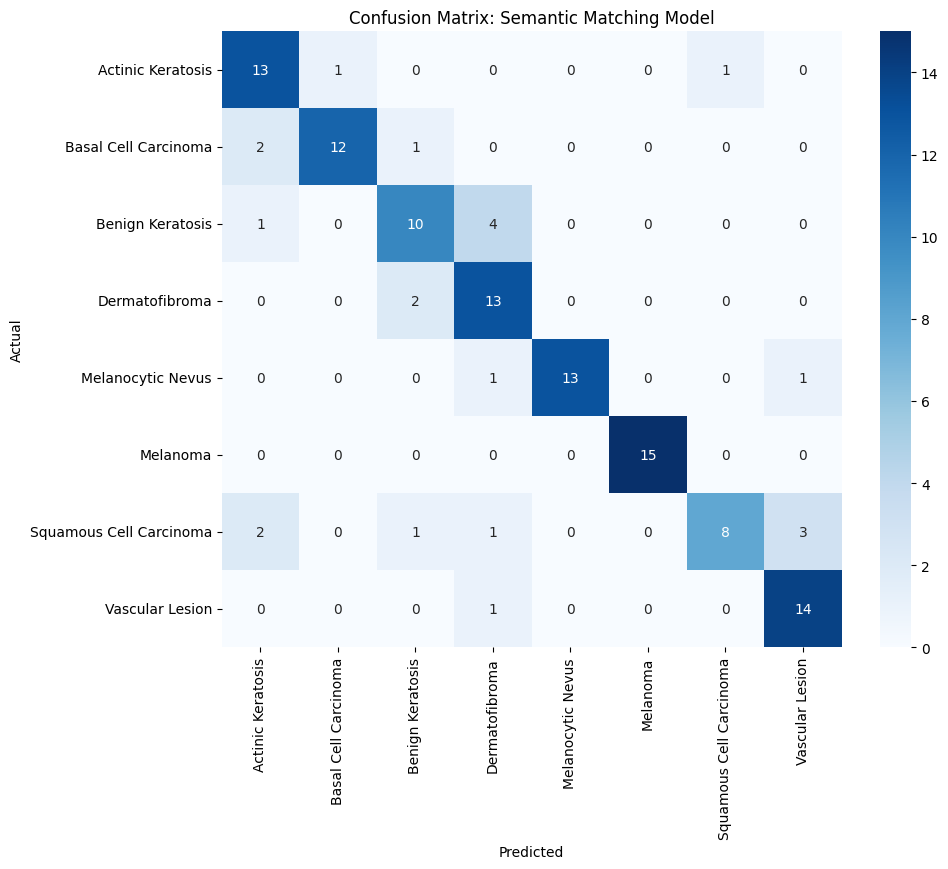


--- Classification Report ---
                         precision    recall  f1-score   support

      Actinic Keratosis       0.72      0.87      0.79        15
   Basal Cell Carcinoma       0.92      0.80      0.86        15
       Benign Keratosis       0.71      0.67      0.69        15
         Dermatofibroma       0.65      0.87      0.74        15
      Melanocytic Nevus       1.00      0.87      0.93        15
               Melanoma       1.00      1.00      1.00        15
Squamous Cell Carcinoma       0.89      0.53      0.67        15
        Vascular Lesion       0.78      0.93      0.85        15

               accuracy                           0.82       120
              macro avg       0.83      0.82      0.82       120
           weighted avg       0.83      0.82      0.82       120


--- ROC Curves ---


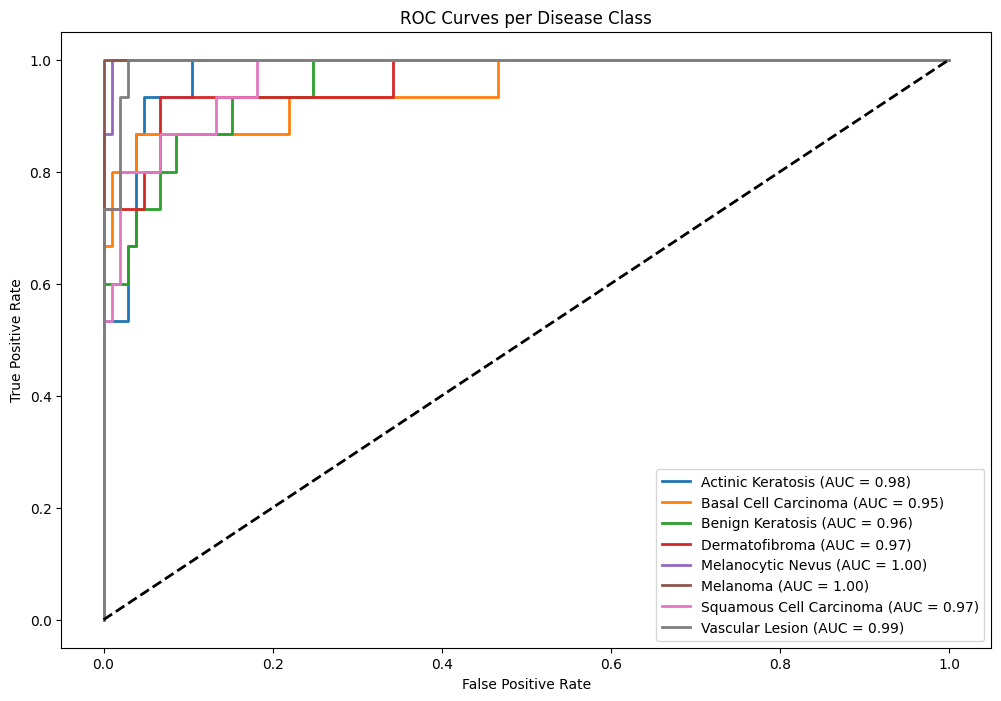

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==========================================
# 1. DEFINE CUSTOM LAYER (Crucial for Loading)
# ==========================================
# Keras needs this class definition to understand the saved model
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# ==========================================
# 2. LOAD ARTIFACTS
# ==========================================
print("--- Loading Saved Artifacts ---")
base_path = "/content/drive/MyDrive/LLMSKIN"

# Load Tokenizer
with open(f"{base_path}/text_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load Label Encoder
with open(f"{base_path}/text_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load Model (passing the custom Attention layer)
print("Loading Model...")
model = load_model(f"{base_path}/best_bilstm2.0_model.keras",
                   custom_objects={'Attention': Attention})
print("✅ Model & Artifacts Loaded Successfully.")

# ==========================================
# 3. RECONSTRUCT DATA PIPELINE
# ==========================================
print("\n--- Reconstructing Validation Data ---")
# Configuration (Must match training config)
MAX_NARRATIVE_LEN = 200
MAX_OPTION_LEN = 8

# Load original data to recreate the split
df = pd.read_csv(f"{base_path}/narratives.csv")
df = df.dropna(subset=['text', 'label'])

# 1. Encode Labels
df['label_idx'] = label_encoder.transform(df['label'])
unique_labels = label_encoder.classes_

# 2. Process Narratives
X_narrative = tokenizer.texts_to_sequences(df['text'])
X_narrative = pad_sequences(X_narrative, maxlen=MAX_NARRATIVE_LEN, padding='post')

# 3. Process Options Chain
option_seqs = tokenizer.texts_to_sequences(unique_labels)
X_options = pad_sequences(option_seqs, maxlen=MAX_OPTION_LEN, padding='post')

# 4. Split Data (Using SAME random_state=42 as training to ensure consistency)
_, X_val_txt, _, y_val = train_test_split(
    X_narrative, df['label_idx'].values,
    test_size=0.2, random_state=42, stratify=df['label_idx']
)

# 5. Tile Options for Validation Set
# Shape becomes: (Num_Val_Samples, 8, 10)
X_val_opts = np.tile(np.expand_dims(X_options, 0), (len(X_val_txt), 1, 1))

print(f"Validation Data Ready: {len(X_val_txt)} samples")

# ==========================================
# 4. GENERATE PREDICTIONS
# ==========================================
print("\n--- Running Inference ---")
y_pred_probs = model.predict([X_val_txt, X_val_opts], verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# ==========================================
# 5. VISUALIZATION & REPORTS
# ==========================================

# --- A. Confusion Matrix ---
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)
plt.title('Confusion Matrix: Semantic Matching Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- B. Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_val, y_pred_classes, target_names=unique_labels))

# --- C. ROC Curves ---
print("\n--- ROC Curves ---")
y_val_bin = label_binarize(y_val, classes=np.arange(len(unique_labels)))
n_classes = y_val_bin.shape[1]

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{unique_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC Curves per Disease Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


#FINAL MODEL: A Multimodal Approach to The Detection and Classification of Skin Lesions

This code builds a production-grade diagnostic model designed to handle real-world data inconsistency (specifically missing patient history).

**Architecture (Y-Shaped):**
Image Branch: Processes 2048-dim features.
Text Branch: Processes 128-dim Bi-LSTM & chain of options features (extracted from pre-trained NLP model).

**Fusion:** The two branches are Concatenated and passed through final Dense layers for classification.

**Key Innovation:** The Robust Data Generator The MultimodalDataGenerator is the "brain" of this script. It uses three techniques to prevent overfitting and handle missing data:

1. Text Dropout: Randomly "blinds" the text branch (inputs zeros) during training. This teaches the model to not crash if a patient uploads a photo without a description.
2. Dynamic Pairing: Instead of using fixed pairs, it matches an image with any random text description from the same disease class, acting as powerful data augmentation.
3. Noise Injection: Adds random static to text vectors to stabilize learning.

--- Loading Data & Extracting Features ---
Extracting text vectors...
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step

--- Starting Robust Training ---
Epoch 1/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.6165 - loss: 1.1496 - val_accuracy: 0.9121 - val_loss: 0.3022
Epoch 2/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8771 - loss: 0.4019 - val_accuracy: 0.9347 - val_loss: 0.2309
Epoch 3/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.9060 - loss: 0.3010 - val_accuracy: 0.9420 - val_loss: 0.2012
Epoch 4/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9166 - loss: 0.2739 - val_accuracy: 0.9452 - val_loss: 0.1954
Epoch 5/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9292 - loss: 0.2251 - val_accuracy: 0.9518 - val_loss: 0.1700
Epoch 6/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9317 - loss: 0.2223 - val_accuracy: 0.9505 - val_loss: 0.1696
Epoch 7/50
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9372 - l

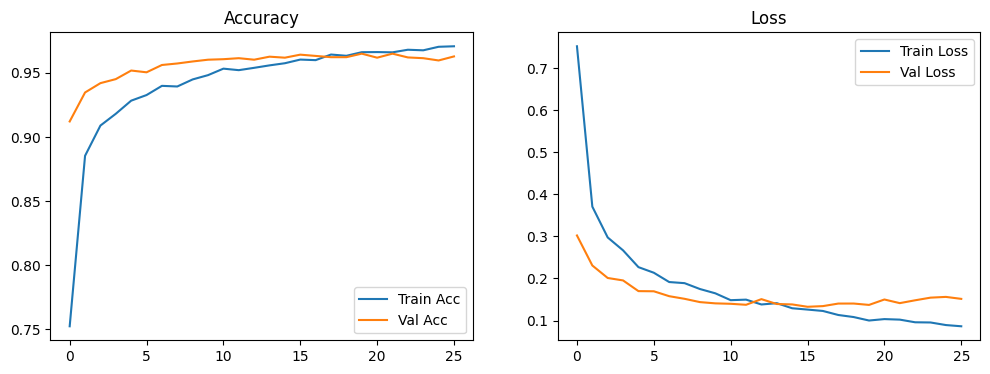

Generating predictions for confusion matrix...


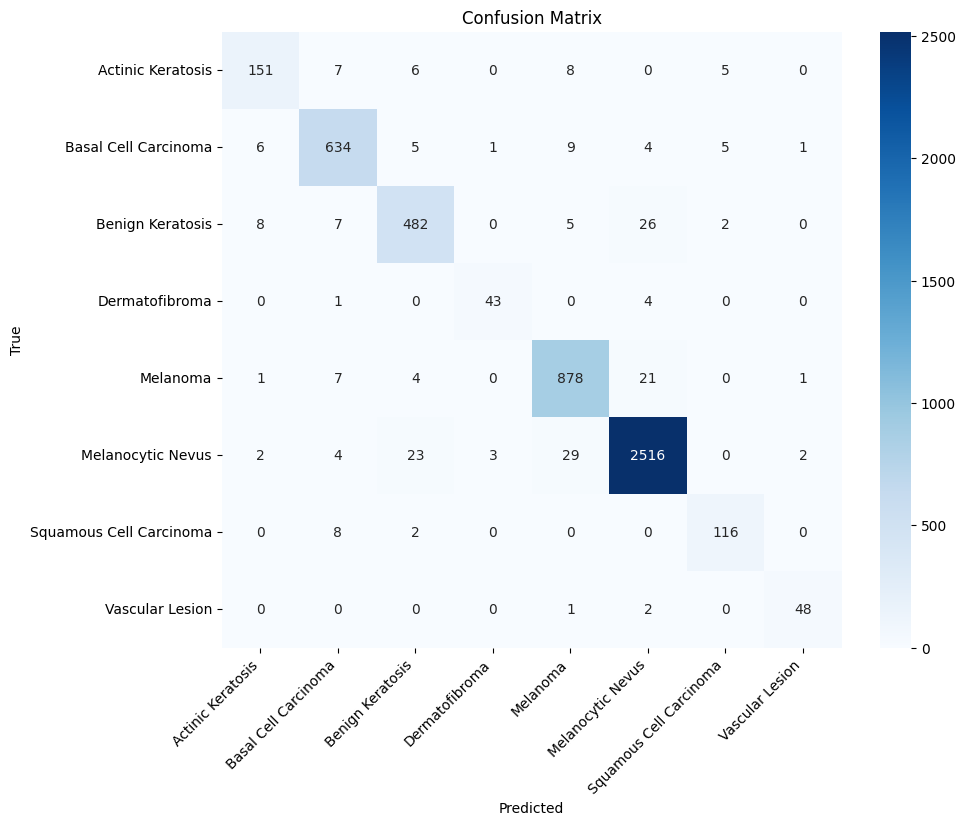


Classification Report:
                         precision    recall  f1-score   support

      Actinic Keratosis       0.90      0.85      0.88       177
   Basal Cell Carcinoma       0.95      0.95      0.95       665
       Benign Keratosis       0.92      0.91      0.92       530
         Dermatofibroma       0.91      0.90      0.91        48
               Melanoma       0.94      0.96      0.95       912
      Melanocytic Nevus       0.98      0.98      0.98      2579
Squamous Cell Carcinoma       0.91      0.92      0.91       126
        Vascular Lesion       0.92      0.94      0.93        51

               accuracy                           0.96      5088
              macro avg       0.93      0.93      0.93      5088
           weighted avg       0.96      0.96      0.96      5088


--- Loading CNN Backbone for Inference ---


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# ==========================================
# 1. CUSTOM LAYERS (Required to load Text Model)
# ==========================================
@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# ==========================================
# 2. CONFIGURATION
# ==========================================
IMAGE_FEATURES_PATH = '/content/drive/MyDrive/DEEPLEARNINGSKINMODEL/isic_features_full.npz'
TEXT_MODEL_PATH = '/content/drive/MyDrive/LLMSKIN/best_bilstm2.0_model.keras'
NARRATIVES_PATH = "/content/drive/MyDrive/LLMSKIN/narratives.csv"
TOKENIZER_PATH = "/content/drive/MyDrive/LLMSKIN/text_tokenizer.pkl"

# Classes
CLASS_NAMES = [
    'Actinic Keratosis', 'Basal Cell Carcinoma', 'Benign Keratosis',
    'Dermatofibroma', 'Melanoma', 'Melanocytic Nevus',
    'Squamous Cell Carcinoma', 'Vascular Lesion'
]

# ==========================================
# 3. FEATURE EXTRACTION & SETUP
# ==========================================
print("--- Loading Data & Extracting Features ---")

# A. Load Image Features
img_data = np.load(IMAGE_FEATURES_PATH)
X_img_all = img_data['features']
y_img_all = img_data['labels']

# B. Load Text Model & Tokenizer
text_model = tf.keras.models.load_model(TEXT_MODEL_PATH, custom_objects={'Attention': Attention})
df_text = pd.read_csv(NARRATIVES_PATH).dropna(subset=['text', 'label'])

if os.path.exists(TOKENIZER_PATH):
    with open(TOKENIZER_PATH, "rb") as f:
        tokenizer = pickle.load(f)
else:
    from tensorflow.keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer(num_words=8000, oov_token="<unk>")
    tokenizer.fit_on_texts(df_text['text'])

# C. Extract Text Embeddings
MAX_NARRATIVE_LEN = 200
X_seq = tokenizer.texts_to_sequences(df_text['text'])
X_seq_padded = pad_sequences(X_seq, maxlen=MAX_NARRATIVE_LEN, padding='post')

# Define extraction model (Cutting at attention layer)
layer_name = 'narrative_attention'
narrative_input_tensor = text_model.inputs[0]
intermediate_layer_model = Model(inputs=narrative_input_tensor, outputs=text_model.get_layer(layer_name).output)

print("Extracting text vectors...")
X_text_features = intermediate_layer_model.predict(X_seq_padded, verbose=1)

# D. Map Text Features to Classes
text_label_map = {name: i for i, name in enumerate(CLASS_NAMES)}
# Handle slight naming variations if necessary (e.g. 'Nevus' -> 'Melanocytic Nevus')
# Adjust map based on your CSV's actual string values
csv_label_map = text_label_map.copy()
csv_label_map['Nevus'] = 5 # Map generic Nevus to Melanocytic Nevus

y_text_mapped = df_text['label'].map(csv_label_map).values

# Filter valid entries
valid_indices = ~np.isnan(y_text_mapped)
X_text_features = X_text_features[valid_indices]
y_text_mapped = y_text_mapped[valid_indices].astype(int)

# Create Dictionary: Class -> List of Vectors
text_feat_dict = {}
for i in range(8):
    text_feat_dict[i] = X_text_features[y_text_mapped == i]

# ==========================================
# 4. ROBUST DATA GENERATOR
# ==========================================
class MultimodalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_img, y_img, text_feat_dict, batch_size=32, shuffle=True,
                 text_dropout_rate=0.2, noise_std=0.05):
        super().__init__()
        self.x_img = x_img
        self.y_img = y_img
        self.text_feat_dict = text_feat_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.text_dropout_rate = text_dropout_rate
        self.noise_std = noise_std
        self.indices = np.arange(len(self.x_img))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x_img) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_x_img = self.x_img[batch_indices]
        batch_y = self.y_img[batch_indices]

        batch_x_text = []
        for label in batch_y:
            if np.random.random() < self.text_dropout_rate:
                batch_x_text.append(np.zeros(128, dtype='float32'))
            else:
                available_texts = self.text_feat_dict.get(label, [])
                if len(available_texts) > 0:
                    rand_idx = np.random.randint(len(available_texts))
                    base_vector = available_texts[rand_idx]
                    noise = np.random.normal(0, self.noise_std, base_vector.shape)
                    batch_x_text.append(base_vector + noise)
                else:
                    batch_x_text.append(np.zeros(128, dtype='float32'))

        batch_x_text = np.array(batch_x_text, dtype='float32')
        return {'image_input': batch_x_img, 'text_input': batch_x_text}, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ==========================================
# 5. TRAINING
# ==========================================
X_train_img, X_val_img, y_train, y_val = train_test_split(
    X_img_all, y_img_all, test_size=0.2, random_state=42, stratify=y_img_all
)

train_gen = MultimodalDataGenerator(X_train_img, y_train, text_feat_dict, batch_size=32, text_dropout_rate=0.2, noise_std=0.05)
val_gen = MultimodalDataGenerator(X_val_img, y_val, text_feat_dict, batch_size=32, text_dropout_rate=0.0, noise_std=0.0)

def build_multimodal_model(img_dim=2048, text_dim=128, num_classes=8):
    img_input = Input(shape=(img_dim,), name='image_input')
    x1 = Dense(512, activation='relu')(img_input)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.5)(x1)

    text_input = Input(shape=(text_dim,), name='text_input')
    x2 = Dense(64, activation='relu')(text_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)

    combined = Concatenate()([x1, x2])
    z = Dense(256, activation='relu')(combined)
    z = Dropout(0.4)(z)
    z = Dense(128, activation='relu')(z)
    output = Dense(num_classes, activation='softmax')(z)

    model = Model(inputs=[img_input, text_input], outputs=output)
    return model

model = build_multimodal_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Starting Robust Training ---")
history = model.fit(train_gen, validation_data=val_gen, epochs=50,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                               tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best_multimodal_skin_fusion.keras', save_best_only=True)])

# ==========================================
# 6. EVALUATION & VISUALIZATION
# ==========================================

def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

def evaluate_confusion_matrix(model, val_gen):
    # Generate predictions for the whole validation set
    print("Generating predictions for confusion matrix...")
    y_true = []
    y_pred = []

    # Iterate through generator to ensure correct order
    # Note: We create a temporary non-shuffling generator for evaluation
    eval_gen = MultimodalDataGenerator(X_val_img, y_val, text_feat_dict, batch_size=32, shuffle=False, text_dropout_rate=0.0)

    for i in range(len(eval_gen)):
        batch_X, batch_y = eval_gen[i]
        preds = model.predict_on_batch(batch_X)
        y_true.extend(batch_y)
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Run Evaluation
plot_performance(history)
evaluate_confusion_matrix(model, val_gen)



In [ ]:
# Create a generator that forces ALL text to be zero (100% dropout)
test_blind_gen = MultimodalDataGenerator(
    X_val_img, y_val, text_feat_dict,
    batch_size=32,
    text_dropout_rate=1.0,  # <--- 100% Dropout (No text allowed)
    noise_std=0.0
)

print("Evaluating Visual-Only Performance...")
loss, acc = model.evaluate(test_blind_gen)
print(f"Accuracy without Text: {acc*100:.2f}%")

Evaluating Visual-Only Performance...
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9352 - loss: 0.2347
Accuracy without Text: 93.32%
